# IS THUG GOOD ENOUGH ON ITS OWN?

First, we try to answer whether THUG is good enough on its own. This is unlikely since it doesn't have a way to move much in the gradient direction.

In [5]:
import numpy as np
from numpy import zeros, eye, array, diag, exp, ones, tanh, cosh, dstack, log, hstack, vstack, sinh
from numpy.linalg import solve, norm
from numpy.random import choice, default_rng, randint, randn
from scipy.stats import multivariate_normal as MVN
from scipy.special import logsumexp, ndtr
from scipy.stats import uniform as udist
import math
import time
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import rc
from ipywidgets.widgets import IntSlider
from ipywidgets.widgets import interact
from warnings import resetwarnings, catch_warnings, filterwarnings
import seaborn as sns
import pickle

from Manifolds.GKManifoldNew import GKManifold, data_generator, find_point_on_manifold, find_point_on_manifold_from_θ
from markov_snippets import MSAdaptive, SMCAdaptive
from tangential_hug_functions import TangentialHugSampler
from tangential_hug_functions import HugTangentialMultivariate
from RWM import RWM
from utils import ESS_univariate
from utils import send_notification_to_iphone

In [2]:
seed = 1234
m = 20     # number of latent variables
d = m + 4  # dimensionality of x-component

In [86]:
def generate_settings(
    d=d, 
    N=2000,
    B=20,
    δ=0.01,
    δmin=1e-3,
    δmax=100.0,
    εmin=1e-16,
    min_pm=1e-4,
    maxiter=500,
    verbose=False,
    εs_fixed=None,
    adaptiveε=True,
    adaptiveδ=False,
    z0_manual=None,
    pm_target=0.23,
    pd_target=0.4,
    dm_target=0.01,
    pm_switch=0.1,
    prior_seed=seed,
    low_memory=True,
    integrator='rwm',
    εprop_switch=0.01,
    ε0_manual=None,
    quantile_value=0.9,
    initialization='manual',
    switch_strategy='pm',
    kernel='uniform',
    prior_scale=7,
    thinning=10,
    burnin=100,
    use_autograd=False,
    stopping_criterion={'εmin', 'pm'},
    resampling_seed=1234,
    mh_kernel_seed=1234,
    resampling_scheme='multinomial',
    prop_hug=0.5,
    projection_method='qr',
    metropolised=False,
    δadaptation_method='ap',
    prop_esjd=0.95,
    adaptiveB=False,
    Bmin=5,
    Bmax=100,
    proxy_ap_metric='dm',
    adaptiveN=False,
    NBbudget=None,
    Badaptation_method=None,
    adaptive_prophug=False,
    min_prop_hug=0.1,
    max_prop_hug=0.9):
    # here d represents m+4
    # Generate the manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=seed)  # Observed data
    q         = MVN(zeros(d), eye(d))             # Proposal distribution for THUG
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type=kernel, use_autograd=use_autograd)
    # grab arguments
    arguments = locals()
    return arguments

In [4]:
N      = 500
B      = 30
δmin   = 1e-3
min_pm = 1e-4
pm_switch = 0.1

Fix the same budget $\Omega=50\,000$ and see how THUG behaves for different B-N pairs.

Grab the initial particles

In [10]:
with open("experiment93/second_particles10k.pkl", "rb") as file:
    P1_10k = pickle.load(file)

with open("experiment93/second_particles10k_new.pkl", "rb") as file:
    P2_10k = pickle.load(file)
    
with open("experiment93/second_particles10k_new_new.pkl", "rb") as file:
    P3_10k = pickle.load(file)
    
P_25k = vstack((P1_10k, P2_10k, P3_10k[:5000]))

Next, run for several settings.

In [11]:
B2N25k_THUG = MSAdaptive(generate_settings(d=d, N=25000, B=2,
        δ=0.01, δmin=δmin, min_pm=(1/25000), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=P_25k, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='thug',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95, Badaptation_method=None))
B2N25k_THUG_PARTICLES = B2N25k_THUG.sample()

Integrator: THUG.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 60.5597001559183070
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6702399999999999
	Particle Diversity: 0.4181200000000000
	Moved Diversity: 0.2802407488000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 34.0013123113222306
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6653200000000000
	Particle Diversity: 0.4326800000000000
	Moved Diversity: 0.2878706576000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 24.7967905795013195
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	V

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6815600000000001
	Particle Diversity: 0.4967200000000000
	Moved Diversity: 0.3385444832000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  24
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 11.8449808564874637
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6898000000000000
	Particle Diversity: 0.5004400000000000
	Moved Diversity: 0.3452035120000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 11.8435037990541687
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6902800000000000
	Particle Diversity: 0.4991600000000000
	Moved Diversity: 0.3445601648000000
	Step-size kept fixed at: 0.0100000000000000

	Trajectories constructed.
	Epsilon: 11.8109996619832884
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6810800000000000
	Particle Diversity: 0.4977600000000000
	Moved Diversity: 0.3390143808000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  47
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 11.8094288879217775
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6846400000000000
	Particle Diversity: 0.4972000000000000
	Moved Diversity: 0.3404030080000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 11.8078310972923859
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6763600000000000
	Particle Diversity: 0.4977600000000000
	Moved Diversity: 0.3366

	Trajectories constructed.
	Epsilon: 11.7509720006139169
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6841600000000000
	Particle Diversity: 0.4961600000000000
	Moved Diversity: 0.3394528256000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 11.7467023163040327
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6856400000000000
	Particle Diversity: 0.4986000000000000
	Moved Diversity: 0.3418601040000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 11.7424087096316008
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6817600000000000
	Particle Diversity: 0.4996000000000000
	Moved Diversity: 0.3406

	Trajectories constructed.
	Epsilon: 11.6185034927647841
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6828800000000000
	Particle Diversity: 0.4944400000000000
	Moved Diversity: 0.3376431872000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  93
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 11.6112868562072968
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6816400000000000
	Particle Diversity: 0.4967600000000000
	Moved Diversity: 0.3386114864000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 11.6038797013388102
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6844400000000000
	Particle Diversity: 0.4984400000000000
	Moved Diversity: 0.3411

	Trajectories constructed.
	Epsilon: 11.4298225616103348
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6750000000000000
	Particle Diversity: 0.4951600000000000
	Moved Diversity: 0.3342330000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  116
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 11.4206375182792339
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6788800000000000
	Particle Diversity: 0.4982800000000000
	Moved Diversity: 0.3382723264000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 11.4112373004596304
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6758400000000000
	Particle Diversity: 0.4946000000000000
	Moved Diversity: 0.33

	Trajectories constructed.
	Epsilon: 11.1862775057047941
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6798400000000000
	Particle Diversity: 0.4913600000000000
	Moved Diversity: 0.3340461824000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  139
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 11.1752220836012217
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6740000000000000
	Particle Diversity: 0.4942000000000000
	Moved Diversity: 0.3330908000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 11.1640868240064286
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6774000000000000
	Particle Diversity: 0.4940000000000000
	Moved Diversity: 0.33

	Trajectories constructed.
	Epsilon: 10.9243953730425289
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6777200000000000
	Particle Diversity: 0.4993600000000000
	Moved Diversity: 0.3384262592000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  162
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.9124488619061992
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6824400000000000
	Particle Diversity: 0.4940800000000000
	Moved Diversity: 0.3371799552000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.9002883384561748
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6760800000000000
	Particle Diversity: 0.4928000000000000
	Moved Diversity: 0.33

	Trajectories constructed.
	Epsilon: 10.6466956810764550
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6837200000000000
	Particle Diversity: 0.4941600000000000
	Moved Diversity: 0.3378670752000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  185
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.6346122561157248
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6770400000000000
	Particle Diversity: 0.4916400000000000
	Moved Diversity: 0.3328599456000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  186
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.6219159641253800
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6770800000000000
	Particle Diversity: 0.4936800000000000
	Moved Diversity: 0.33

	Trajectories constructed.
	Epsilon: 10.3708799972746988
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6800400000000000
	Particle Diversity: 0.4969200000000000
	Moved Diversity: 0.3379254768000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  208
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.3593728442253212
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6784800000000000
	Particle Diversity: 0.4933200000000000
	Moved Diversity: 0.3347077536000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  209
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.3480000787560833
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6729600000000000
	Particle Diversity: 0.4965600000000000
	Moved Diversity: 0.33

	Trajectories constructed.
	Epsilon: 10.1201657227377755
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6768400000000000
	Particle Diversity: 0.4930000000000000
	Moved Diversity: 0.3336821200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  231
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.1101949504778013
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6774800000000000
	Particle Diversity: 0.4925200000000000
	Moved Diversity: 0.3336724496000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  232
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.1001596957657362
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6827200000000000
	Particle Diversity: 0.4944400000000000
	Moved Diversity: 0.33

	Trajectories constructed.
	Epsilon: 9.9026038841277302
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6833200000000000
	Particle Diversity: 0.4961600000000000
	Moved Diversity: 0.3390360512000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  254
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.8939446221834721
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6762000000000000
	Particle Diversity: 0.4980800000000000
	Moved Diversity: 0.3368016960000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  255
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.8853090978598601
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6790800000000000
	Particle Diversity: 0.4999200000000000
	Moved Diversity: 0.33948

	Trajectories constructed.
	Epsilon: 9.7161135937985144
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6744400000000000
	Particle Diversity: 0.4958400000000000
	Moved Diversity: 0.3344143296000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  277
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.7084620348742785
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6796800000000000
	Particle Diversity: 0.4957200000000000
	Moved Diversity: 0.3369309696000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  278
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.7008138102204313
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6835200000000000
	Particle Diversity: 0.4988800000000000
	Moved Diversity: 0.34099

	Trajectories constructed.
	Epsilon: 9.5458814286715565
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6738000000000000
	Particle Diversity: 0.4950800000000000
	Moved Diversity: 0.3335849040000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  300
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.5392411583344980
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6778000000000000
	Particle Diversity: 0.4972800000000000
	Moved Diversity: 0.3370563840000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  301
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.5325484873749318
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6778000000000000
	Particle Diversity: 0.4984800000000000
	Moved Diversity: 0.33786

	Trajectories constructed.
	Epsilon: 9.4020073507007762
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6759200000000000
	Particle Diversity: 0.5000400000000000
	Moved Diversity: 0.3379870368000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  323
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.3963017214641944
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6738400000000000
	Particle Diversity: 0.4929200000000000
	Moved Diversity: 0.3321492128000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  324
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.3905241409399434
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6720800000000000
	Particle Diversity: 0.4976400000000000
	Moved Diversity: 0.33445

	Trajectories constructed.
	Epsilon: 9.2779659347967041
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6713200000000000
	Particle Diversity: 0.4912800000000000
	Moved Diversity: 0.3298060896000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  346
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.2730995110513739
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6791199999999999
	Particle Diversity: 0.4961600000000000
	Moved Diversity: 0.3369521792000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  347
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.2683941536942775
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6756400000000000
	Particle Diversity: 0.4952400000000000
	Moved Diversity: 0.33460

	Trajectories constructed.
	Epsilon: 9.1732574799913529
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6755600000000000
	Particle Diversity: 0.4968000000000000
	Moved Diversity: 0.3356182080000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  369
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.1689753800194822
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6717200000000000
	Particle Diversity: 0.4976400000000000
	Moved Diversity: 0.3342747408000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  370
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.1647006639208399
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6751200000000001
	Particle Diversity: 0.4952800000000000
	Moved Diversity: 0.33437

	Trajectories constructed.
	Epsilon: 9.0816396378443862
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6760000000000000
	Particle Diversity: 0.4973600000000000
	Moved Diversity: 0.3362153600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  392
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.0779836558757712
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6739600000000000
	Particle Diversity: 0.4932000000000000
	Moved Diversity: 0.3323970720000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  393
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.0742542101605466
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6699200000000000
	Particle Diversity: 0.4957200000000000
	Moved Diversity: 0.33209

	Trajectories constructed.
	Epsilon: 9.0020042759234755
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6721600000000000
	Particle Diversity: 0.4944000000000000
	Moved Diversity: 0.3323159040000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  415
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.9987289945522413
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6804800000000000
	Particle Diversity: 0.4961200000000000
	Moved Diversity: 0.3375997376000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  416
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.9954601920879007
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6782800000000000
	Particle Diversity: 0.4952000000000000
	Moved Diversity: 0.33588

	Trajectories constructed.
	Epsilon: 8.9323934075950326
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6761600000000000
	Particle Diversity: 0.4969600000000000
	Moved Diversity: 0.3360244736000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  438
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.9294884014725397
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6725200000000000
	Particle Diversity: 0.4959200000000000
	Moved Diversity: 0.3335161184000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  439
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.9266931052460112
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6720800000000000
	Particle Diversity: 0.4960800000000000
	Moved Diversity: 0.33340

	Trajectories constructed.
	Epsilon: 8.8702730098258087
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6636000000000000
	Particle Diversity: 0.4954000000000000
	Moved Diversity: 0.3287474400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  461
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.8677980849801781
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6736000000000000
	Particle Diversity: 0.4956800000000000
	Moved Diversity: 0.3338900480000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  462
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.8652256030966399
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6756400000000000
	Particle Diversity: 0.4949200000000000
	Moved Diversity: 0.33438

	Trajectories constructed.
	Epsilon: 8.8173181058490577
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6735600000000000
	Particle Diversity: 0.4927600000000000
	Moved Diversity: 0.3319034256000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  484
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.8151538723404457
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6806800000000000
	Particle Diversity: 0.4942000000000000
	Moved Diversity: 0.3363920559999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  485
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.8129436953568501
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6675200000000000
	Particle Diversity: 0.4954400000000000
	Moved Diversity: 0.33071

In [12]:
with open("experiment94/B2N25k_THUG_ess.pkl", "wb") as file:
    pickle.dump(B2N25k_THUG.ESS, file)
    
with open("experiment94/B2N25k_THUG_ess_smc.pkl", "wb") as file:
    pickle.dump(B2N25k_THUG.ESS_SMC, file)
    
with open("experiment94/B2N25k_THUG_epsilons.pkl", "wb") as file:
    pickle.dump(B2N25k_THUG.εs, file)
    
with open("experiment94/B2N25k_THUG_pm.pkl", "wb") as file:
    pickle.dump(B2N25k_THUG.PROP_MOVED, file)
    
with open("experiment94/B2N25k_THUG_pd.pkl", "wb") as file:
    pickle.dump(B2N25k_THUG.P_DIVERSITY, file)
    
with open("experiment94/B2N25k_THUG_dm.pkl", "wb") as file:
    pickle.dump(B2N25k_THUG.DIV_MOVED, file)

In [16]:
B5N25k_THUG = MSAdaptive(generate_settings(d=d, N=10000, B=5,
        δ=0.01, δmin=δmin, min_pm=(1/10000), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=P1_10k, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='thug',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95, Badaptation_method=None))
B5N25k_THUG_THUG_PARTICLES = B5N25k_THUG.sample()

Integrator: THUG.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 55.0069753305084248
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8354000000000000
	Particle Diversity: 0.4460000000000000
	Moved Diversity: 0.3725884000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 32.5428521486919848
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8406000000000000
	Particle Diversity: 0.4326000000000000
	Moved Diversity: 0.3636435600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 25.0717057344529302
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	V

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8139000000000000
	Particle Diversity: 0.4746000000000000
	Moved Diversity: 0.3862769400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  24
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.7058184071242124
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8199000000000000
	Particle Diversity: 0.4808000000000000
	Moved Diversity: 0.3942079200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.7052049163981504
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8223000000000000
	Particle Diversity: 0.4750000000000000
	Moved Diversity: 0.3905925000000000
	Step-size kept fixed at: 0.0100000000000000

	Trajectories constructed.
	Epsilon: 13.6941992921658411
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8024000000000000
	Particle Diversity: 0.4816000000000000
	Moved Diversity: 0.3864358400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  47
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6938312300096641
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8058999999999999
	Particle Diversity: 0.4767000000000000
	Moved Diversity: 0.3841725300000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6934742459192869
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7957000000000000
	Particle Diversity: 0.4791000000000000
	Moved Diversity: 0.3812

	Trajectories constructed.
	Epsilon: 13.6847071805266101
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7907000000000000
	Particle Diversity: 0.4719000000000000
	Moved Diversity: 0.3731313300000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6843638737285627
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7901000000000000
	Particle Diversity: 0.4773000000000000
	Moved Diversity: 0.3771147300000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6840145696642566
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7938000000000000
	Particle Diversity: 0.4779000000000000
	Moved Diversity: 0.3793

	Trajectories constructed.
	Epsilon: 13.6760238311604141
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7957000000000000
	Particle Diversity: 0.4754000000000000
	Moved Diversity: 0.3782757800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  93
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6756499194874905
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8007000000000000
	Particle Diversity: 0.4732000000000000
	Moved Diversity: 0.3788912400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6752600444752552
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8016000000000000
	Particle Diversity: 0.4747000000000000
	Moved Diversity: 0.3805

	Trajectories constructed.
	Epsilon: 13.6678769144959915
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7959000000000001
	Particle Diversity: 0.4728000000000000
	Moved Diversity: 0.3763015200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  116
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6675267149704496
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8012000000000000
	Particle Diversity: 0.4725000000000000
	Moved Diversity: 0.3785670000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6671683774398005
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8033000000000000
	Particle Diversity: 0.4808000000000000
	Moved Diversity: 0.38

	Trajectories constructed.
	Epsilon: 13.6596948251854258
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8044000000000000
	Particle Diversity: 0.4783000000000000
	Moved Diversity: 0.3847445200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  139
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6593543118735816
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8095000000000000
	Particle Diversity: 0.4844000000000000
	Moved Diversity: 0.3921218000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6590141542875223
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8100000000000001
	Particle Diversity: 0.4802000000000000
	Moved Diversity: 0.38

	Trajectories constructed.
	Epsilon: 13.6519433194110835
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8149000000000000
	Particle Diversity: 0.4867000000000000
	Moved Diversity: 0.3966118300000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  162
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6516270308255940
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8156000000000000
	Particle Diversity: 0.4891000000000000
	Moved Diversity: 0.3989099600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6513110591530911
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8143000000000000
	Particle Diversity: 0.4849000000000000
	Moved Diversity: 0.39

	Trajectories constructed.
	Epsilon: 13.6446818179497438
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8201000000000001
	Particle Diversity: 0.4865000000000000
	Moved Diversity: 0.3989786500000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  185
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6443229385302267
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8286000000000000
	Particle Diversity: 0.4790000000000000
	Moved Diversity: 0.3968994000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  186
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6439484258367933
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8158000000000000
	Particle Diversity: 0.4845000000000000
	Moved Diversity: 0.39

	Trajectories constructed.
	Epsilon: 13.6365138489664321
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8175000000000000
	Particle Diversity: 0.4862000000000000
	Moved Diversity: 0.3974685000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  208
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6361330304236894
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8169000000000000
	Particle Diversity: 0.4846000000000000
	Moved Diversity: 0.3958697400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  209
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6357679693177438
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8156000000000000
	Particle Diversity: 0.4837000000000000
	Moved Diversity: 0.39

	Trajectories constructed.
	Epsilon: 13.6275355478435483
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8200000000000000
	Particle Diversity: 0.4787000000000000
	Moved Diversity: 0.3925340000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  231
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6271315617814217
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8132000000000000
	Particle Diversity: 0.4829000000000000
	Moved Diversity: 0.3926942800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  232
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6267060445742789
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8253000000000000
	Particle Diversity: 0.4735000000000000
	Moved Diversity: 0.39

	Trajectories constructed.
	Epsilon: 13.6171173549515867
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8181000000000000
	Particle Diversity: 0.4888000000000000
	Moved Diversity: 0.3998872800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  254
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6167126092459227
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8108000000000000
	Particle Diversity: 0.4890000000000000
	Moved Diversity: 0.3964812000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  255
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6162987920073526
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8193000000000000
	Particle Diversity: 0.4861000000000000
	Moved Diversity: 0.39

	Trajectories constructed.
	Epsilon: 13.6062725419447972
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8262000000000000
	Particle Diversity: 0.4853000000000000
	Moved Diversity: 0.4009548600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  277
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6057523522781487
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8325000000000000
	Particle Diversity: 0.4878000000000000
	Moved Diversity: 0.4060935000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  278
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6052714232365766
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8266000000000000
	Particle Diversity: 0.4855000000000000
	Moved Diversity: 0.40

	Trajectories constructed.
	Epsilon: 13.5922147563483957
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8340000000000000
	Particle Diversity: 0.4844000000000000
	Moved Diversity: 0.4039896000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  300
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.5915953917004515
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8320000000000000
	Particle Diversity: 0.4807000000000000
	Moved Diversity: 0.3999424000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  301
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.5909372836784677
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8246000000000000
	Particle Diversity: 0.4770000000000000
	Moved Diversity: 0.39

	Trajectories constructed.
	Epsilon: 13.5791534556742093
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8347000000000000
	Particle Diversity: 0.4938000000000000
	Moved Diversity: 0.4121748600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  323
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.5785421965964286
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8360000000000000
	Particle Diversity: 0.4931000000000000
	Moved Diversity: 0.4122316000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  324
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.5779227441567318
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8307000000000000
	Particle Diversity: 0.4876000000000000
	Moved Diversity: 0.40

	Trajectories constructed.
	Epsilon: 13.5635623568092534
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8313000000000000
	Particle Diversity: 0.4894000000000000
	Moved Diversity: 0.4068382200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  346
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.5628768763647489
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8352000000000001
	Particle Diversity: 0.4901000000000000
	Moved Diversity: 0.4093315200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  347
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.5621862737246257
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8401000000000000
	Particle Diversity: 0.4911000000000000
	Moved Diversity: 0.41

	Trajectories constructed.
	Epsilon: 13.5448854935351655
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8344000000000000
	Particle Diversity: 0.4893000000000000
	Moved Diversity: 0.4082719200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  369
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.5439721371620010
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8307000000000000
	Particle Diversity: 0.4803000000000000
	Moved Diversity: 0.3989852100000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  370
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.5430736548278610
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8288000000000000
	Particle Diversity: 0.4862000000000000
	Moved Diversity: 0.40

	Trajectories constructed.
	Epsilon: 13.5238606888435413
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8304000000000000
	Particle Diversity: 0.4830000000000000
	Moved Diversity: 0.4010832000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  392
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.5229088418463856
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8335000000000000
	Particle Diversity: 0.4836000000000000
	Moved Diversity: 0.4030806000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  393
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.5219784044060383
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8360000000000000
	Particle Diversity: 0.4873000000000000
	Moved Diversity: 0.40

	Trajectories constructed.
	Epsilon: 13.4998227866888492
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8347000000000000
	Particle Diversity: 0.4875000000000000
	Moved Diversity: 0.4069162500000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  415
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.4989644759165142
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8300999999999999
	Particle Diversity: 0.4886000000000000
	Moved Diversity: 0.4055868599999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  416
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.4981312122807768
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8308000000000000
	Particle Diversity: 0.4887000000000000
	Moved Diversity: 0.40

	Trajectories constructed.
	Epsilon: 13.4788968104528308
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8350000000000000
	Particle Diversity: 0.4855000000000000
	Moved Diversity: 0.4053925000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  438
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.4779879940013494
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8336000000000000
	Particle Diversity: 0.4831000000000000
	Moved Diversity: 0.4027121600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  439
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.4770539918661072
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8366000000000000
	Particle Diversity: 0.4849000000000000
	Moved Diversity: 0.40

	Trajectories constructed.
	Epsilon: 13.4575312083405798
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8371000000000000
	Particle Diversity: 0.4876000000000000
	Moved Diversity: 0.4081699599999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  461
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.4566106800375405
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8317000000000000
	Particle Diversity: 0.4863000000000000
	Moved Diversity: 0.4044557100000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  462
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.4557197102784336
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8340000000000000
	Particle Diversity: 0.4888000000000000
	Moved Diversity: 0.40

	Trajectories constructed.
	Epsilon: 13.4304370251574667
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8350000000000000
	Particle Diversity: 0.4917000000000000
	Moved Diversity: 0.4105695000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  484
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.4294454548169764
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8318000000000000
	Particle Diversity: 0.4825000000000000
	Moved Diversity: 0.4013435000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  485
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.4285005906866548
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8333000000000000
	Particle Diversity: 0.4887000000000000
	Moved Diversity: 0.40

In [17]:
with open("experiment94/B5N25k_THUG_ess.pkl", "wb") as file:
    pickle.dump(B5N25k_THUG.ESS, file)
    
with open("experiment94/B5N25k_THUG_ess_smc.pkl", "wb") as file:
    pickle.dump(B5N25k_THUG.ESS_SMC, file)
    
with open("experiment94/B5N25k_THUG_epsilons.pkl", "wb") as file:
    pickle.dump(B5N25k_THUG.εs, file)
    
with open("experiment94/B5N25k_THUG_pm.pkl", "wb") as file:
    pickle.dump(B5N25k_THUG.PROP_MOVED, file)
    
with open("experiment94/B5N25k_THUG_pd.pkl", "wb") as file:
    pickle.dump(B5N25k_THUG.P_DIVERSITY, file)
    
with open("experiment94/B5N25k_THUG_dm.pkl", "wb") as file:
    pickle.dump(B5N25k_THUG.DIV_MOVED, file)

In [21]:
B20N2k_THUG = MSAdaptive(generate_settings(d=d, N=2500, B=20,
        δ=0.01, δmin=δmin, min_pm=(1/2500), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=P1_10k[:2500], pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='thug',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95, Badaptation_method=None))
B20N2k_THUG_PARTICLES = B20N2k_THUG.sample()

Integrator: THUG.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 54.7133582196436166
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9452000000000000
	Particle Diversity: 0.4300000000000000
	Moved Diversity: 0.4064360000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 32.3405678511221026
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9576000000000000
	Particle Diversity: 0.4232000000000000
	Moved Diversity: 0.4052563200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 24.2790916147789630
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	V

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9228000000000000
	Particle Diversity: 0.4408000000000000
	Moved Diversity: 0.4067702400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  24
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.7000250458231285
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9300000000000000
	Particle Diversity: 0.4576000000000000
	Moved Diversity: 0.4255680000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6992966869942610
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9268000000000000
	Particle Diversity: 0.4620000000000000
	Moved Diversity: 0.4281816000000000
	Step-size kept fixed at: 0.0100000000000000

	Trajectories constructed.
	Epsilon: 13.6835103838818561
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9332000000000000
	Particle Diversity: 0.4740000000000000
	Moved Diversity: 0.4423368000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  47
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6827916676345680
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9404000000000000
	Particle Diversity: 0.4768000000000000
	Moved Diversity: 0.4483827200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6822316689157901
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9424000000000000
	Particle Diversity: 0.4648000000000000
	Moved Diversity: 0.4380

	Trajectories constructed.
	Epsilon: 13.6744639935507983
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9404000000000000
	Particle Diversity: 0.4688000000000000
	Moved Diversity: 0.4408595200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6740738836031390
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9424000000000000
	Particle Diversity: 0.4776000000000000
	Moved Diversity: 0.4500902400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6737156517275213
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9392000000000000
	Particle Diversity: 0.4844000000000000
	Moved Diversity: 0.4549

	Trajectories constructed.
	Epsilon: 13.6644383986854514
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9468000000000000
	Particle Diversity: 0.4852000000000000
	Moved Diversity: 0.4593873600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  93
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6640401667955889
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9364000000000000
	Particle Diversity: 0.4756000000000000
	Moved Diversity: 0.4453518400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6635664441212530
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9379999999999999
	Particle Diversity: 0.4780000000000000
	Moved Diversity: 0.4483

	Trajectories constructed.
	Epsilon: 13.6528744862622062
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9512000000000000
	Particle Diversity: 0.4836000000000000
	Moved Diversity: 0.4600003200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  116
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6523897892612229
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9396000000000000
	Particle Diversity: 0.4844000000000000
	Moved Diversity: 0.4551422400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6517797768657214
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9412000000000000
	Particle Diversity: 0.4860000000000000
	Moved Diversity: 0.45

	Trajectories constructed.
	Epsilon: 13.6383482193547270
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9460000000000000
	Particle Diversity: 0.4980000000000000
	Moved Diversity: 0.4711080000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  139
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6378856389541685
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9520000000000000
	Particle Diversity: 0.4920000000000000
	Moved Diversity: 0.4683840000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6373729440299982
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9379999999999999
	Particle Diversity: 0.4776000000000000
	Moved Diversity: 0.44

	Trajectories constructed.
	Epsilon: 13.6256666664915222
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9464000000000000
	Particle Diversity: 0.4784000000000000
	Moved Diversity: 0.4527577600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  162
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6250889423515105
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9468000000000000
	Particle Diversity: 0.4896000000000000
	Moved Diversity: 0.4635532800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6245643884647105
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9456000000000000
	Particle Diversity: 0.4864000000000000
	Moved Diversity: 0.45

	Trajectories constructed.
	Epsilon: 13.6087308920961743
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9456000000000000
	Particle Diversity: 0.4768000000000000
	Moved Diversity: 0.4508620800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  185
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6078048536409497
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9452000000000000
	Particle Diversity: 0.4776000000000000
	Moved Diversity: 0.4514275200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  186
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.6067428688702634
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9352000000000000
	Particle Diversity: 0.4744000000000000
	Moved Diversity: 0.44

	Trajectories constructed.
	Epsilon: 13.5837864416827756
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9392000000000000
	Particle Diversity: 0.4792000000000000
	Moved Diversity: 0.4500646400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  208
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.5827992157870572
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9476000000000000
	Particle Diversity: 0.4724000000000000
	Moved Diversity: 0.4476462400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  209
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.5817015185219461
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9456000000000000
	Particle Diversity: 0.4820000000000000
	Moved Diversity: 0.45

	Trajectories constructed.
	Epsilon: 13.5522762724336836
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9332000000000000
	Particle Diversity: 0.4680000000000000
	Moved Diversity: 0.4367376000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  231
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.5506229699023297
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9356000000000000
	Particle Diversity: 0.4688000000000000
	Moved Diversity: 0.4386092800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  232
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.5489731309210235
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9436000000000000
	Particle Diversity: 0.4628000000000000
	Moved Diversity: 0.43

	Trajectories constructed.
	Epsilon: 13.4526652483742755
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9147999999999999
	Particle Diversity: 0.4216000000000000
	Moved Diversity: 0.3856796800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  254
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.4428829298857515
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9276000000000000
	Particle Diversity: 0.4256000000000000
	Moved Diversity: 0.3947865600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  255
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.4335613450952280
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9336000000000000
	Particle Diversity: 0.4132000000000000
	Moved Diversity: 0.38

	Trajectories constructed.
	Epsilon: 13.2238485807239421
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9336000000000000
	Particle Diversity: 0.4308000000000000
	Moved Diversity: 0.4021948800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  277
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.2136972885929271
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9156000000000000
	Particle Diversity: 0.4172000000000000
	Moved Diversity: 0.3819883200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  278
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.2037868016757400
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9220000000000000
	Particle Diversity: 0.4316000000000000
	Moved Diversity: 0.39

	Trajectories constructed.
	Epsilon: 13.0954752492285884
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9167999999999999
	Particle Diversity: 0.4232000000000000
	Moved Diversity: 0.3879897600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  300
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.0926187768226239
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9072000000000000
	Particle Diversity: 0.4216000000000000
	Moved Diversity: 0.3824755200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  301
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.0899143758021754
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9156000000000000
	Particle Diversity: 0.4268000000000000
	Moved Diversity: 0.39

	Trajectories constructed.
	Epsilon: 13.0585029936222128
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8804000000000000
	Particle Diversity: 0.4428000000000000
	Moved Diversity: 0.3898411200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  323
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.0577116373135382
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8672000000000000
	Particle Diversity: 0.4368000000000000
	Moved Diversity: 0.3787929600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  324
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.0569538716304852
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8792000000000000
	Particle Diversity: 0.4420000000000000
	Moved Diversity: 0.38

	Trajectories constructed.
	Epsilon: 13.0134007229474928
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9232000000000000
	Particle Diversity: 0.4400000000000000
	Moved Diversity: 0.4062080000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  346
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.0106335572225795
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9268000000000000
	Particle Diversity: 0.4676000000000000
	Moved Diversity: 0.4333716800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  347
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 13.0086803767055557
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9132000000000000
	Particle Diversity: 0.4632000000000000
	Moved Diversity: 0.42

	Trajectories constructed.
	Epsilon: 12.9863658256137491
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9000000000000000
	Particle Diversity: 0.4128000000000000
	Moved Diversity: 0.3715200000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  369
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 12.9830070860042053
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8980000000000000
	Particle Diversity: 0.4208000000000000
	Moved Diversity: 0.3778784000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  370
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 12.9793177363702412
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9096000000000000
	Particle Diversity: 0.4124000000000000
	Moved Diversity: 0.37

	Trajectories constructed.
	Epsilon: 12.9076683157213967
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9020000000000000
	Particle Diversity: 0.4180000000000000
	Moved Diversity: 0.3770360000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  392
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 12.9059088007807965
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8988000000000000
	Particle Diversity: 0.4236000000000000
	Moved Diversity: 0.3807316800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  393
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 12.9040279416244328
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9084000000000000
	Particle Diversity: 0.4256000000000000
	Moved Diversity: 0.38

	Trajectories constructed.
	Epsilon: 12.8580063803061826
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9127999999999999
	Particle Diversity: 0.4496000000000000
	Moved Diversity: 0.4103948800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  415
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 12.8550065711642105
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9164000000000000
	Particle Diversity: 0.4456000000000000
	Moved Diversity: 0.4083478400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  416
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 12.8527922212613390
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9084000000000000
	Particle Diversity: 0.4348000000000000
	Moved Diversity: 0.39

	Trajectories constructed.
	Epsilon: 12.8299689415598408
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9000000000000000
	Particle Diversity: 0.4176000000000000
	Moved Diversity: 0.3758400000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  438
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 12.8282557780979900
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9048000000000000
	Particle Diversity: 0.4112000000000000
	Moved Diversity: 0.3720537600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  439
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 12.8258443628431174
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8992000000000000
	Particle Diversity: 0.4220000000000000
	Moved Diversity: 0.37

	Trajectories constructed.
	Epsilon: 12.7715249742970869
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9116000000000000
	Particle Diversity: 0.4320000000000000
	Moved Diversity: 0.3938112000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  461
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 12.7691964587506881
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9052000000000000
	Particle Diversity: 0.4328000000000000
	Moved Diversity: 0.3917705600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  462
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 12.7670734959712053
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9092000000000000
	Particle Diversity: 0.4284000000000000
	Moved Diversity: 0.38

	Trajectories constructed.
	Epsilon: 12.7263240008663843
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8848000000000000
	Particle Diversity: 0.4392000000000000
	Moved Diversity: 0.3886041600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  484
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 12.7252982411508668
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8648000000000000
	Particle Diversity: 0.4372000000000000
	Moved Diversity: 0.3780905600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  485
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 12.7241666647567566
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8844000000000000
	Particle Diversity: 0.4296000000000000
	Moved Diversity: 0.37

In [22]:
with open("experiment94/B20N2k_THUG_ess.pkl", "wb") as file:
    pickle.dump(B20N2k_THUG.ESS, file)
    
with open("experiment94/B20N2k_THUG_ess_smc.pkl", "wb") as file:
    pickle.dump(B20N2k_THUG.ESS_SMC, file)
    
with open("experiment94/B20N2k_THUG_epsilons.pkl", "wb") as file:
    pickle.dump(B20N2k_THUG.εs, file)
    
with open("experiment94/B20N2k_THUG_pm.pkl", "wb") as file:
    pickle.dump(B20N2k_THUG.PROP_MOVED, file)
    
with open("experiment94/B20N2k_THUG_pd.pkl", "wb") as file:
    pickle.dump(B20N2k_THUG.P_DIVERSITY, file)
    
with open("experiment94/B20N2k_THUG_dm.pkl", "wb") as file:
    pickle.dump(B20N2k_THUG.DIV_MOVED, file)

Should be clear that THUG on its own is not good enough. Now we look at HAN (HUG AND NHUG)

# HUG AND NHUG

Would be nice to first try it for different values of `prop_hug` and see what kind of values we get. Then, it would be interesting to adapt it based on the empirical proportions of particles moved on each side. Eventually, we want to adapt everything.

### Prop-hug=0.5

##### B=10, N=5000

In [73]:
B10N5k_HAN_05 = MSAdaptive(generate_settings(d=d, N=5000, B=10,
        δ=0.01, δmin=δmin, min_pm=(1/5000), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=P1_10k[:5000], pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='hug_and_nhug',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=1000, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95, Badaptation_method=None, prop_hug=0.5))
B10N5k_HAN_05_PARTICLES = B10N5k_HAN_05.sample()

Integrator: HUG + NHUG.
Prop Hug  :  0.5
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 55.2105774338382034
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9108000000000001
	Particle Diversity: 0.4548000000000000
	Moved Diversity: 0.4142318400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 32.9880819866830421
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9126000000000000
	Particle Diversity: 0.4438000000000000
	Moved Diversity: 0.4050118799999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 25.4669938809784391
	Weights computed and normalized.
	SMC Weights computed and normalized.
	

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9088000000000001
	Particle Diversity: 0.4798000000000000
	Moved Diversity: 0.4360422400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  24
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.4820140765590573
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9024000000000000
	Particle Diversity: 0.4794000000000000
	Moved Diversity: 0.4326105600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.0735106273538086
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9022000000000000
	Particle Diversity: 0.4824000000000000
	Moved Diversity: 0.4352212800000000
	Step-size kept fixed at: 0.0100000000000000
I

	Trajectories constructed.
	Epsilon: 5.3786261035588776
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8726000000000000
	Particle Diversity: 0.4618000000000000
	Moved Diversity: 0.4029666800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  47
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.3461776196929698
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8708000000000000
	Particle Diversity: 0.4574000000000000
	Moved Diversity: 0.3983039200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.3092144033573403
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8678000000000000
	Particle Diversity: 0.4620000000000000
	Moved Diversity: 0.4009236

	Trajectories constructed.
	Epsilon: 4.5869344953701212
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8816000000000001
	Particle Diversity: 0.4524000000000000
	Moved Diversity: 0.3988358400000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.5331863409029198
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8752000000000000
	Particle Diversity: 0.4714000000000000
	Moved Diversity: 0.4125692800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.4910634395073288
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8752000000000000
	Particle Diversity: 0.4660000000000000
	Moved Diversity: 0.4078432

	Trajectories constructed.
	Epsilon: 3.8420757853443810
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8612000000000000
	Particle Diversity: 0.4582000000000000
	Moved Diversity: 0.3946018400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  93
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.8231557292003062
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8616000000000000
	Particle Diversity: 0.4622000000000000
	Moved Diversity: 0.3982315200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.8070063684741884
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8620000000000000
	Particle Diversity: 0.4652000000000000
	Moved Diversity: 0.4010024

	Trajectories constructed.
	Epsilon: 3.6290954198056848
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8472000000000000
	Particle Diversity: 0.4744000000000000
	Moved Diversity: 0.4019116800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  116
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6215150150941309
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8450000000000000
	Particle Diversity: 0.4690000000000000
	Moved Diversity: 0.3963050000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6140180951560517
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8526000000000000
	Particle Diversity: 0.4554000000000000
	Moved Diversity: 0.38827

	Trajectories constructed.
	Epsilon: 3.4985844713213825
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8380000000000000
	Particle Diversity: 0.4672000000000000
	Moved Diversity: 0.3915136000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  139
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.4895525332038808
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8524000000000000
	Particle Diversity: 0.4520000000000000
	Moved Diversity: 0.3852848000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.4775882691849733
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8574000000000001
	Particle Diversity: 0.4548000000000000
	Moved Diversity: 0.38994

	Trajectories constructed.
	Epsilon: 3.2286039315921449
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8682000000000000
	Particle Diversity: 0.4662000000000000
	Moved Diversity: 0.4047548400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  162
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.2039167252460463
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8673999999999999
	Particle Diversity: 0.4610000000000000
	Moved Diversity: 0.3998714000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.1757008012179400
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8660000000000000
	Particle Diversity: 0.4594000000000000
	Moved Diversity: 0.39784

	Trajectories constructed.
	Epsilon: 2.4907768544485380
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8656000000000000
	Particle Diversity: 0.4624000000000000
	Moved Diversity: 0.4002534400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  185
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.4686563831800967
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8588000000000000
	Particle Diversity: 0.4648000000000000
	Moved Diversity: 0.3991702400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  186
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.4417284630131530
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8683999999999999
	Particle Diversity: 0.4592000000000000
	Moved Diversity: 0.39876

	Trajectories constructed.
	Epsilon: 1.6194536242274691
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8570000000000000
	Particle Diversity: 0.4584000000000000
	Moved Diversity: 0.3928488000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  208
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5980641432494236
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8536000000000000
	Particle Diversity: 0.4614000000000000
	Moved Diversity: 0.3938510400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  209
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5789107128248201
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8550000000000000
	Particle Diversity: 0.4636000000000000
	Moved Diversity: 0.39637

	Trajectories constructed.
	Epsilon: 1.2090700840469215
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8430000000000000
	Particle Diversity: 0.4576000000000000
	Moved Diversity: 0.3857568000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  231
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1817454044920344
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8552000000000000
	Particle Diversity: 0.4548000000000000
	Moved Diversity: 0.3889449600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  232
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1564964212814068
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8506000000000000
	Particle Diversity: 0.4634000000000000
	Moved Diversity: 0.39416

	Trajectories constructed.
	Epsilon: 0.8946562532838200
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8398000000000000
	Particle Diversity: 0.4652000000000000
	Moved Diversity: 0.3906749600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  254
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8863040281061668
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8316000000000000
	Particle Diversity: 0.4626000000000000
	Moved Diversity: 0.3846981600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  255
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8770894697053695
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8320000000000000
	Particle Diversity: 0.4584000000000000
	Moved Diversity: 0.38138

	Trajectories constructed.
	Epsilon: 0.7858757552785041
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8058000000000000
	Particle Diversity: 0.4552000000000000
	Moved Diversity: 0.3668001600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  277
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7843333361213266
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8084000000000000
	Particle Diversity: 0.4556000000000000
	Moved Diversity: 0.3683070400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  278
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7826376577657805
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8096000000000000
	Particle Diversity: 0.4566000000000000
	Moved Diversity: 0.36966

	Trajectories constructed.
	Epsilon: 0.7442402856160987
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8086000000000000
	Particle Diversity: 0.4600000000000000
	Moved Diversity: 0.3719560000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  300
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7427603918938050
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8172000000000000
	Particle Diversity: 0.4654000000000000
	Moved Diversity: 0.3803248800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  301
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7417739503442649
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8038000000000000
	Particle Diversity: 0.4732000000000000
	Moved Diversity: 0.38035

	Trajectories constructed.
	Epsilon: 0.7277440462759162
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7688000000000000
	Particle Diversity: 0.4510000000000000
	Moved Diversity: 0.3467288000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  323
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7274632121070286
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7806000000000000
	Particle Diversity: 0.4502000000000000
	Moved Diversity: 0.3514261200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  324
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7272041687241804
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7610000000000000
	Particle Diversity: 0.4492000000000000
	Moved Diversity: 0.34184

	Trajectories constructed.
	Epsilon: 0.7185820994473958
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8064000000000000
	Particle Diversity: 0.4388000000000000
	Moved Diversity: 0.3538483200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  346
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7154520843528819
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8094000000000000
	Particle Diversity: 0.4372000000000000
	Moved Diversity: 0.3538696800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  347
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7135218613300656
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8169999999999999
	Particle Diversity: 0.4702000000000000
	Moved Diversity: 0.38415

	Trajectories constructed.
	Epsilon: 0.6943910965267091
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7640000000000000
	Particle Diversity: 0.4332000000000000
	Moved Diversity: 0.3309648000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  369
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6941511449142217
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8139999999999999
	Particle Diversity: 0.4346000000000000
	Moved Diversity: 0.3537644000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  370
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6917037394856559
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8222000000000000
	Particle Diversity: 0.4606000000000000
	Moved Diversity: 0.37870

	Trajectories constructed.
	Epsilon: 0.6178080068969580
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8458000000000000
	Particle Diversity: 0.4848000000000000
	Moved Diversity: 0.4100438400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  392
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6072554420336432
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8352000000000001
	Particle Diversity: 0.4910000000000000
	Moved Diversity: 0.4100832000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  393
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5969050948623552
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8326000000000000
	Particle Diversity: 0.4838000000000000
	Moved Diversity: 0.40281

	Trajectories constructed.
	Epsilon: 0.5430828557075905
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8036000000000000
	Particle Diversity: 0.4718000000000000
	Moved Diversity: 0.3791384800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  415
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5423620286594222
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8088000000000000
	Particle Diversity: 0.4650000000000000
	Moved Diversity: 0.3760920000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  416
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5417902016201190
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7982000000000000
	Particle Diversity: 0.4482000000000000
	Moved Diversity: 0.35775

	Trajectories constructed.
	Epsilon: 0.5241654327887268
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8306000000000000
	Particle Diversity: 0.4636000000000000
	Moved Diversity: 0.3850661600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  438
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5230333899951198
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8264000000000000
	Particle Diversity: 0.4688000000000000
	Moved Diversity: 0.3874163200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  439
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5221358156429149
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8078000000000000
	Particle Diversity: 0.4672000000000000
	Moved Diversity: 0.37740

	Trajectories constructed.
	Epsilon: 0.5106404622650998
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7403999999999999
	Particle Diversity: 0.4336000000000000
	Moved Diversity: 0.3210374400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  461
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5103711289492919
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7426000000000000
	Particle Diversity: 0.4444000000000000
	Moved Diversity: 0.3300114400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  462
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5101283879809804
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7462000000000000
	Particle Diversity: 0.4410000000000000
	Moved Diversity: 0.32907

	Trajectories constructed.
	Epsilon: 0.5068331463133448
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6714000000000000
	Particle Diversity: 0.4394000000000000
	Moved Diversity: 0.2950131600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  484
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5067395616695033
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6514000000000000
	Particle Diversity: 0.4296000000000000
	Moved Diversity: 0.2798414400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  485
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5066524358041511
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6454000000000000
	Particle Diversity: 0.4296000000000000
	Moved Diversity: 0.27726

	Trajectories constructed.
	Epsilon: 0.4938571922128084
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8474000000000000
	Particle Diversity: 0.4860000000000000
	Moved Diversity: 0.4118364000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  507
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4859086183525068
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8428000000000000
	Particle Diversity: 0.4946000000000000
	Moved Diversity: 0.4168488800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  508
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4697628134050931
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8400000000000000
	Particle Diversity: 0.4822000000000000
	Moved Diversity: 0.40504

	Trajectories constructed.
	Epsilon: 0.2809184570782369
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8064000000000000
	Particle Diversity: 0.4510000000000000
	Moved Diversity: 0.3636864000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  530
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2782270005800066
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8010000000000000
	Particle Diversity: 0.4614000000000000
	Moved Diversity: 0.3695814000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  531
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2757510533511423
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8086000000000000
	Particle Diversity: 0.4592000000000000
	Moved Diversity: 0.37130

	Trajectories constructed.
	Epsilon: 0.2368562246035827
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8120000000000001
	Particle Diversity: 0.4560000000000000
	Moved Diversity: 0.3702720000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  553
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2345582217160466
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8154000000000000
	Particle Diversity: 0.4482000000000000
	Moved Diversity: 0.3654622800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  554
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2319470474309153
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8110000000000001
	Particle Diversity: 0.4622000000000000
	Moved Diversity: 0.37484

	Trajectories constructed.
	Epsilon: 0.2097236173811181
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7706000000000000
	Particle Diversity: 0.4440000000000000
	Moved Diversity: 0.3421464000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  576
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2091122291554420
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7658000000000000
	Particle Diversity: 0.4520000000000000
	Moved Diversity: 0.3461416000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  577
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2085811009011003
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7594000000000000
	Particle Diversity: 0.4404000000000000
	Moved Diversity: 0.33443

	Trajectories constructed.
	Epsilon: 0.2037177405597298
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5704000000000000
	Particle Diversity: 0.4256000000000000
	Moved Diversity: 0.2427622400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  599
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2036409521306582
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5659999999999999
	Particle Diversity: 0.4318000000000000
	Moved Diversity: 0.2443988000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  600
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2035693774637075
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5730000000000000
	Particle Diversity: 0.4284000000000000
	Moved Diversity: 0.24547

	Trajectories constructed.
	Epsilon: 0.1966944826185746
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6690000000000000
	Particle Diversity: 0.4350000000000000
	Moved Diversity: 0.2910150000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  622
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1965569660343146
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6435999999999999
	Particle Diversity: 0.4362000000000000
	Moved Diversity: 0.2807383200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  623
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1964292896046324
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6512000000000000
	Particle Diversity: 0.4254000000000000
	Moved Diversity: 0.27702

	Trajectories constructed.
	Epsilon: 0.1879090820750254
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6294000000000000
	Particle Diversity: 0.4310000000000000
	Moved Diversity: 0.2712714000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  645
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1877981007491443
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5868000000000000
	Particle Diversity: 0.4308000000000000
	Moved Diversity: 0.2527934400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  646
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1877161721833689
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5634000000000000
	Particle Diversity: 0.4394000000000000
	Moved Diversity: 0.24755

	Trajectories constructed.
	Epsilon: 0.1859882844047570
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4674000000000000
	Particle Diversity: 0.4230000000000000
	Moved Diversity: 0.1977102000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  668
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1859509180921583
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4624000000000000
	Particle Diversity: 0.4326000000000000
	Moved Diversity: 0.2000342400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  669
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1859156286640424
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4402000000000000
	Particle Diversity: 0.4282000000000000
	Moved Diversity: 0.18849

	Trajectories constructed.
	Epsilon: 0.1832559589166834
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7824000000000000
	Particle Diversity: 0.4444000000000000
	Moved Diversity: 0.3476985600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  691
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1823942911074881
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7598000000000000
	Particle Diversity: 0.4592000000000000
	Moved Diversity: 0.3489001600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  692
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1819426343322974
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7458000000000000
	Particle Diversity: 0.4518000000000000
	Moved Diversity: 0.33695

	Trajectories constructed.
	Epsilon: 0.1804081106210130
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4442000000000000
	Particle Diversity: 0.4352000000000000
	Moved Diversity: 0.1933158400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  714
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1803764127548956
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4366000000000000
	Particle Diversity: 0.4300000000000000
	Moved Diversity: 0.1877380000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  715
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1803451439643990
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4226000000000000
	Particle Diversity: 0.4268000000000000
	Moved Diversity: 0.18036

	Trajectories constructed.
	Epsilon: 0.1774491405514488
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3836000000000000
	Particle Diversity: 0.4212000000000000
	Moved Diversity: 0.1615723200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  737
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1774232032893311
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3592000000000000
	Particle Diversity: 0.4342000000000000
	Moved Diversity: 0.1559646400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  738
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1773984655162626
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3696000000000000
	Particle Diversity: 0.4274000000000000
	Moved Diversity: 0.15796

	Trajectories constructed.
	Epsilon: 0.1770042673242012
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3290000000000000
	Particle Diversity: 0.4088000000000000
	Moved Diversity: 0.1344952000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  760
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1769858897890877
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3276000000000000
	Particle Diversity: 0.4144000000000000
	Moved Diversity: 0.1357574400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  761
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1769684183526739
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3160000000000000
	Particle Diversity: 0.4050000000000000
	Moved Diversity: 0.12798

	Trajectories constructed.
	Epsilon: 0.1705391804857929
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4610000000000000
	Particle Diversity: 0.4334000000000000
	Moved Diversity: 0.1997974000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  783
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1705060749692299
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4478000000000000
	Particle Diversity: 0.4334000000000000
	Moved Diversity: 0.1940765200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  784
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1704773029143753
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4260000000000000
	Particle Diversity: 0.4222000000000000
	Moved Diversity: 0.17985

	Trajectories constructed.
	Epsilon: 0.1700511375616405
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3150000000000000
	Particle Diversity: 0.4108000000000000
	Moved Diversity: 0.1294020000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  806
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1700333755166800
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3584000000000000
	Particle Diversity: 0.4104000000000000
	Moved Diversity: 0.1470873600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  807
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1700122355766228
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3404000000000000
	Particle Diversity: 0.4226000000000000
	Moved Diversity: 0.14385

	Trajectories constructed.
	Epsilon: 0.1696282637221247
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3000000000000000
	Particle Diversity: 0.4222000000000000
	Moved Diversity: 0.1266600000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  829
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1696122212917656
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2692000000000000
	Particle Diversity: 0.4332000000000000
	Moved Diversity: 0.1166174400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  830
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1695961672530851
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2994000000000000
	Particle Diversity: 0.4086000000000000
	Moved Diversity: 0.12233

	Trajectories constructed.
	Epsilon: 0.1693185078477511
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2696000000000000
	Particle Diversity: 0.4240000000000000
	Moved Diversity: 0.1143104000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  852
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1693069566487483
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2810000000000000
	Particle Diversity: 0.3986000000000000
	Moved Diversity: 0.1120066000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  853
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1692942468694466
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2594000000000000
	Particle Diversity: 0.4252000000000000
	Moved Diversity: 0.11029

	Trajectories constructed.
	Epsilon: 0.1690553893325892
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2848000000000000
	Particle Diversity: 0.4194000000000000
	Moved Diversity: 0.1194451200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  875
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1690431323281963
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2688000000000000
	Particle Diversity: 0.4150000000000000
	Moved Diversity: 0.1115520000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  876
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1690308273321949
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2418000000000000
	Particle Diversity: 0.4258000000000000
	Moved Diversity: 0.10295

	Trajectories constructed.
	Epsilon: 0.1687930767165103
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2586000000000000
	Particle Diversity: 0.3922000000000000
	Moved Diversity: 0.1014229200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  898
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1687830504888514
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2300000000000000
	Particle Diversity: 0.4062000000000000
	Moved Diversity: 0.0934260000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  899
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1687732176560303
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2390000000000000
	Particle Diversity: 0.4010000000000000
	Moved Diversity: 0.09583

	Trajectories constructed.
	Epsilon: 0.1685722429665186
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2330000000000000
	Particle Diversity: 0.3804000000000000
	Moved Diversity: 0.0886332000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  921
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1685618610770133
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2336000000000000
	Particle Diversity: 0.4136000000000000
	Moved Diversity: 0.0966169600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  922
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1685510304258178
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2232000000000000
	Particle Diversity: 0.4048000000000000
	Moved Diversity: 0.09035

	Trajectories constructed.
	Epsilon: 0.1683783529359718
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1660000000000000
	Particle Diversity: 0.4574000000000000
	Moved Diversity: 0.0759284000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  944
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1683718101782440
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1956000000000000
	Particle Diversity: 0.3376000000000000
	Moved Diversity: 0.0660345600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  945
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1683651576209313
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1688000000000000
	Particle Diversity: 0.4350000000000000
	Moved Diversity: 0.07342

	Trajectories constructed.
	Epsilon: 0.1681717532192068
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2066000000000000
	Particle Diversity: 0.4222000000000000
	Moved Diversity: 0.0872265200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  967
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1681635901212467
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2038000000000000
	Particle Diversity: 0.3934000000000000
	Moved Diversity: 0.0801749200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  968
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1681555796132156
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2132000000000000
	Particle Diversity: 0.4052000000000000
	Moved Diversity: 0.08638

	Trajectories constructed.
	Epsilon: 0.1680054227587441
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1692000000000000
	Particle Diversity: 0.3770000000000000
	Moved Diversity: 0.0637884000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  990
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1679984209995622
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2002000000000000
	Particle Diversity: 0.3678000000000000
	Moved Diversity: 0.0736335600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  991
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1679915824323016
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1898000000000000
	Particle Diversity: 0.3570000000000000
	Moved Diversity: 0.06775

In [31]:
B10N5k_HAN_03 = MSAdaptive(generate_settings(d=d, N=5000, B=10,
        δ=0.01, δmin=δmin, min_pm=(1/5000), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=P1_10k[:5000], pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='hug_and_nhug',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=1000, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95, Badaptation_method=None, prop_hug=0.3))
B10N5k_HAN_03_PARTICLES = B10N5k_HAN_03.sample()

Integrator: HUG + NHUG.
Prop Hug  :  0.3
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 55.2105774338382034
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9094000000000000
	Particle Diversity: 0.4580000000000000
	Moved Diversity: 0.4165052000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 32.0295493223097338
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9127999999999999
	Particle Diversity: 0.4420000000000000
	Moved Diversity: 0.4034576000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 25.2819814622382921
	Weights computed and normalized.
	SMC Weights computed and normalized.
	

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8974000000000000
	Particle Diversity: 0.4744000000000000
	Moved Diversity: 0.4257265600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  24
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.6110303750576520
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8960000000000000
	Particle Diversity: 0.4782000000000000
	Moved Diversity: 0.4284672000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.1872546495208773
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8996000000000000
	Particle Diversity: 0.4752000000000000
	Moved Diversity: 0.4274899200000000
	Step-size kept fixed at: 0.0100000000000000
I

	Trajectories constructed.
	Epsilon: 3.2425407755865958
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8438000000000000
	Particle Diversity: 0.4586000000000000
	Moved Diversity: 0.3869666800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  47
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.1466868385691416
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8370000000000000
	Particle Diversity: 0.4604000000000000
	Moved Diversity: 0.3853547999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0527470770199741
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8346000000000000
	Particle Diversity: 0.4560000000000000
	Moved Diversity: 0.3805776

	Trajectories constructed.
	Epsilon: 1.9326963316175938
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7988000000000000
	Particle Diversity: 0.4566000000000000
	Moved Diversity: 0.3647320800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.9025859714291484
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7818000000000001
	Particle Diversity: 0.4550000000000000
	Moved Diversity: 0.3557190000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8758150282139263
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7850000000000000
	Particle Diversity: 0.4544000000000000
	Moved Diversity: 0.3567040

	Trajectories constructed.
	Epsilon: 1.3748767059464582
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8036000000000000
	Particle Diversity: 0.4594000000000000
	Moved Diversity: 0.3691738400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  93
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3395427637443937
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7926000000000000
	Particle Diversity: 0.4676000000000000
	Moved Diversity: 0.3706197600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3064433208337776
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7836000000000000
	Particle Diversity: 0.4632000000000000
	Moved Diversity: 0.3629635

	Trajectories constructed.
	Epsilon: 0.8856086540843932
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7644000000000000
	Particle Diversity: 0.4714000000000000
	Moved Diversity: 0.3603381600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  116
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8765427190854183
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7784000000000000
	Particle Diversity: 0.4832000000000000
	Moved Diversity: 0.3761228800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8678512151558658
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7690000000000000
	Particle Diversity: 0.4768000000000000
	Moved Diversity: 0.36665

	Trajectories constructed.
	Epsilon: 0.7030477748182582
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7400000000000000
	Particle Diversity: 0.4732000000000000
	Moved Diversity: 0.3501680000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  139
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6950067145345583
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7440000000000000
	Particle Diversity: 0.4666000000000000
	Moved Diversity: 0.3471504000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6878899001910829
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7536000000000000
	Particle Diversity: 0.4722000000000000
	Moved Diversity: 0.35584

	Trajectories constructed.
	Epsilon: 0.5594084623170087
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7322000000000000
	Particle Diversity: 0.4726000000000000
	Moved Diversity: 0.3460377200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  162
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5561977284419739
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7536000000000000
	Particle Diversity: 0.4770000000000000
	Moved Diversity: 0.3594672000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5527191344083492
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7486000000000000
	Particle Diversity: 0.4692000000000000
	Moved Diversity: 0.35124

	Trajectories constructed.
	Epsilon: 0.4755707104737762
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7433999999999999
	Particle Diversity: 0.4568000000000000
	Moved Diversity: 0.3395851200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  185
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4726784154709429
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7280000000000000
	Particle Diversity: 0.4712000000000000
	Moved Diversity: 0.3430336000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  186
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4705330111707863
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7370000000000000
	Particle Diversity: 0.4648000000000000
	Moved Diversity: 0.34255

	Trajectories constructed.
	Epsilon: 0.4146609310221090
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7262000000000000
	Particle Diversity: 0.4628000000000000
	Moved Diversity: 0.3360853600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  208
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4123872161689097
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7486000000000000
	Particle Diversity: 0.4612000000000000
	Moved Diversity: 0.3452543200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  209
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4100650206909988
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7318000000000000
	Particle Diversity: 0.4618000000000000
	Moved Diversity: 0.33794

	Trajectories constructed.
	Epsilon: 0.3276583920640178
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7494000000000000
	Particle Diversity: 0.4822000000000000
	Moved Diversity: 0.3613606800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  231
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3247224956563690
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7452000000000000
	Particle Diversity: 0.4762000000000000
	Moved Diversity: 0.3548642400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  232
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3222796909266208
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7388000000000000
	Particle Diversity: 0.4772000000000000
	Moved Diversity: 0.35255

	Trajectories constructed.
	Epsilon: 0.2697505906926005
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7062000000000000
	Particle Diversity: 0.4584000000000000
	Moved Diversity: 0.3237220800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  254
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2691330798173391
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7002000000000000
	Particle Diversity: 0.4556000000000000
	Moved Diversity: 0.3190111200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  255
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2686085592902157
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7000000000000000
	Particle Diversity: 0.4532000000000000
	Moved Diversity: 0.31724

	Trajectories constructed.
	Epsilon: 0.2543292677913294
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7088000000000000
	Particle Diversity: 0.4646000000000000
	Moved Diversity: 0.3293084800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  277
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2534498962459845
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7238000000000000
	Particle Diversity: 0.4654000000000000
	Moved Diversity: 0.3368565200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  278
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2526137513096132
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7216000000000000
	Particle Diversity: 0.4720000000000000
	Moved Diversity: 0.34059

	Trajectories constructed.
	Epsilon: 0.2394689035928619
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7078000000000000
	Particle Diversity: 0.4598000000000000
	Moved Diversity: 0.3254464400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  300
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2390359777201700
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7030000000000000
	Particle Diversity: 0.4644000000000000
	Moved Diversity: 0.3264732000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  301
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2386802275854927
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6876000000000000
	Particle Diversity: 0.4632000000000000
	Moved Diversity: 0.31849

	Trajectories constructed.
	Epsilon: 0.2095910045604666
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7264000000000000
	Particle Diversity: 0.4550000000000000
	Moved Diversity: 0.3305120000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  323
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2085962913200685
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7224000000000000
	Particle Diversity: 0.4628000000000000
	Moved Diversity: 0.3343267200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  324
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2080616126967572
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7244000000000000
	Particle Diversity: 0.4626000000000000
	Moved Diversity: 0.33510

	Trajectories constructed.
	Epsilon: 0.1820798751823866
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7478000000000000
	Particle Diversity: 0.4714000000000000
	Moved Diversity: 0.3525129200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  346
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1799582279796601
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7433999999999999
	Particle Diversity: 0.4762000000000000
	Moved Diversity: 0.3540070800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  347
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1783446116040198
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7500000000000000
	Particle Diversity: 0.4868000000000000
	Moved Diversity: 0.36510

	Trajectories constructed.
	Epsilon: 0.1637311293796130
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7372000000000000
	Particle Diversity: 0.4746000000000000
	Moved Diversity: 0.3498751200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  369
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1630721632395100
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7324000000000001
	Particle Diversity: 0.4712000000000000
	Moved Diversity: 0.3451068800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  370
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1625813707644795
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7224000000000000
	Particle Diversity: 0.4634000000000000
	Moved Diversity: 0.33476

	Trajectories constructed.
	Epsilon: 0.1417731165221178
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7150000000000000
	Particle Diversity: 0.4658000000000000
	Moved Diversity: 0.3330470000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  392
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1411754114075556
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7106000000000000
	Particle Diversity: 0.4732000000000000
	Moved Diversity: 0.3362559200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  393
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1406328463568709
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7144000000000000
	Particle Diversity: 0.4652000000000000
	Moved Diversity: 0.33233

	Trajectories constructed.
	Epsilon: 0.1303763071612073
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6892000000000000
	Particle Diversity: 0.4418000000000000
	Moved Diversity: 0.3044885600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  415
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1292907687843150
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7200000000000000
	Particle Diversity: 0.4528000000000000
	Moved Diversity: 0.3260160000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  416
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1275410486551304
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7131999999999999
	Particle Diversity: 0.4542000000000000
	Moved Diversity: 0.32393

	Trajectories constructed.
	Epsilon: 0.1157175858596120
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5566000000000000
	Particle Diversity: 0.4506000000000000
	Moved Diversity: 0.2508039600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  438
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1155031314780539
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5802000000000000
	Particle Diversity: 0.4432000000000000
	Moved Diversity: 0.2571446400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  439
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1152524468923433
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5866000000000000
	Particle Diversity: 0.4364000000000000
	Moved Diversity: 0.25599

	Trajectories constructed.
	Epsilon: 0.0984420572649389
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6504000000000000
	Particle Diversity: 0.4550000000000000
	Moved Diversity: 0.2959320000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  461
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0978369881841475
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6526000000000000
	Particle Diversity: 0.4478000000000000
	Moved Diversity: 0.2922342800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  462
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0972615902002065
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6622000000000000
	Particle Diversity: 0.4504000000000000
	Moved Diversity: 0.29825

	Trajectories constructed.
	Epsilon: 0.0813427081642056
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6180000000000000
	Particle Diversity: 0.4504000000000000
	Moved Diversity: 0.2783472000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  484
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0808094314935163
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6060000000000000
	Particle Diversity: 0.4528000000000000
	Moved Diversity: 0.2743968000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  485
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0802966071512753
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5966000000000000
	Particle Diversity: 0.4492000000000000
	Moved Diversity: 0.26799

	Trajectories constructed.
	Epsilon: 0.0725773782675316
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4674000000000000
	Particle Diversity: 0.4356000000000000
	Moved Diversity: 0.2035994400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  507
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0724022476329761
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4698000000000000
	Particle Diversity: 0.4288000000000000
	Moved Diversity: 0.2014502400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  508
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0722300186059940
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4554000000000000
	Particle Diversity: 0.4334000000000000
	Moved Diversity: 0.19737

	Trajectories constructed.
	Epsilon: 0.0695831477545661
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3444000000000000
	Particle Diversity: 0.4228000000000000
	Moved Diversity: 0.1456123200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  530
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0694877154855461
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3224000000000000
	Particle Diversity: 0.4226000000000000
	Moved Diversity: 0.1362462400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  531
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0693961061893976
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3052000000000000
	Particle Diversity: 0.4262000000000000
	Moved Diversity: 0.13007

	Trajectories constructed.
	Epsilon: 0.0676334185743941
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2728000000000000
	Particle Diversity: 0.4218000000000000
	Moved Diversity: 0.1150670400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  553
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0675607841550101
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2636000000000000
	Particle Diversity: 0.4044000000000000
	Moved Diversity: 0.1065998400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  554
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0674985900577102
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2674000000000000
	Particle Diversity: 0.4170000000000000
	Moved Diversity: 0.11150

	Trajectories constructed.
	Epsilon: 0.0662381317059336
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2016000000000000
	Particle Diversity: 0.3822000000000000
	Moved Diversity: 0.0770515200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  576
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0661865860232036
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2242000000000000
	Particle Diversity: 0.4082000000000000
	Moved Diversity: 0.0915184400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  577
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0661382209545526
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2202000000000000
	Particle Diversity: 0.3986000000000000
	Moved Diversity: 0.08777

	Trajectories constructed.
	Epsilon: 0.0649315326813340
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2220000000000000
	Particle Diversity: 0.4128000000000000
	Moved Diversity: 0.0916416000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  599
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0648807942634533
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2178000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.0888624000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  600
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0648293395937207
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2202000000000000
	Particle Diversity: 0.4078000000000000
	Moved Diversity: 0.08979

	Trajectories constructed.
	Epsilon: 0.0636834612201803
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2284000000000000
	Particle Diversity: 0.3660000000000000
	Moved Diversity: 0.0835944000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  622
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0636383504473856
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2012000000000000
	Particle Diversity: 0.4210000000000000
	Moved Diversity: 0.0847052000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  623
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0635935844769816
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1868000000000000
	Particle Diversity: 0.4154000000000000
	Moved Diversity: 0.07759

	Trajectories constructed.
	Epsilon: 0.0626740917246276
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2124000000000000
	Particle Diversity: 0.4090000000000000
	Moved Diversity: 0.0868716000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  645
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0626204623565502
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2148000000000000
	Particle Diversity: 0.4072000000000000
	Moved Diversity: 0.0874665600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  646
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0625682937876279
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1788000000000000
	Particle Diversity: 0.4472000000000000
	Moved Diversity: 0.07995

	Trajectories constructed.
	Epsilon: 0.0617746288539891
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1202000000000000
	Particle Diversity: 0.4152000000000000
	Moved Diversity: 0.0499070400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  668
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0617373541896913
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1630000000000000
	Particle Diversity: 0.3600000000000000
	Moved Diversity: 0.0586800000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  669
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0616989261378613
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1282000000000000
	Particle Diversity: 0.4226000000000000
	Moved Diversity: 0.05417

	Trajectories constructed.
	Epsilon: 0.0608735967249344
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1854000000000000
	Particle Diversity: 0.3892000000000000
	Moved Diversity: 0.0721576800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  691
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0608272181895107
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1568000000000000
	Particle Diversity: 0.4210000000000000
	Moved Diversity: 0.0660128000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  692
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0607875570328388
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1726000000000000
	Particle Diversity: 0.3842000000000000
	Moved Diversity: 0.06631

	Trajectories constructed.
	Epsilon: 0.0600496550205037
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1540000000000000
	Particle Diversity: 0.3232000000000000
	Moved Diversity: 0.0497728000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  714
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0600207359983879
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1298000000000000
	Particle Diversity: 0.3760000000000000
	Moved Diversity: 0.0488048000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  715
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0599884830661006
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1314000000000000
	Particle Diversity: 0.3942000000000000
	Moved Diversity: 0.05179

	Trajectories constructed.
	Epsilon: 0.0593925244943427
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1338000000000000
	Particle Diversity: 0.2410000000000000
	Moved Diversity: 0.0322458000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  737
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0593700281267930
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0876000000000000
	Particle Diversity: 0.4580000000000000
	Moved Diversity: 0.0401208000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  738
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0593419176678391
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1336000000000000
	Particle Diversity: 0.3098000000000000
	Moved Diversity: 0.04138

	Trajectories constructed.
	Epsilon: 0.0586546395828328
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1030000000000000
	Particle Diversity: 0.4174000000000000
	Moved Diversity: 0.0429922000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  760
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0586303518501161
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1144000000000000
	Particle Diversity: 0.3364000000000000
	Moved Diversity: 0.0384841600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  761
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0586013412118780
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1256000000000000
	Particle Diversity: 0.3656000000000000
	Moved Diversity: 0.04591

	Trajectories constructed.
	Epsilon: 0.0580053459042256
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1536000000000000
	Particle Diversity: 0.3530000000000000
	Moved Diversity: 0.0542208000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  783
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0579717452312962
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1266000000000000
	Particle Diversity: 0.4258000000000000
	Moved Diversity: 0.0539062800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  784
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0579370373535982
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0954000000000000
	Particle Diversity: 0.4634000000000000
	Moved Diversity: 0.04420

	Trajectories constructed.
	Epsilon: 0.0574511593573330
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1452000000000000
	Particle Diversity: 0.4322000000000000
	Moved Diversity: 0.0627554400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  806
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0574111173698449
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1740000000000000
	Particle Diversity: 0.3402000000000000
	Moved Diversity: 0.0591948000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  807
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0573808802828419
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1120000000000000
	Particle Diversity: 0.3844000000000000
	Moved Diversity: 0.04305

	Trajectories constructed.
	Epsilon: 0.0568254557062263
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1564000000000000
	Particle Diversity: 0.3904000000000000
	Moved Diversity: 0.0610585600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  829
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0567917395191949
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1408000000000000
	Particle Diversity: 0.4064000000000000
	Moved Diversity: 0.0572211200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  830
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0567589902985827
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1198000000000000
	Particle Diversity: 0.4332000000000000
	Moved Diversity: 0.05189

	Trajectories constructed.
	Epsilon: 0.0562752352104308
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0602000000000000
	Particle Diversity: 0.4928000000000000
	Moved Diversity: 0.0296665600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  852
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0562547399510854
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0388000000000000
	Particle Diversity: 0.5084000000000000
	Moved Diversity: 0.0197259200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  853
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0562389622653621
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0544000000000000
	Particle Diversity: 0.2918000000000000
	Moved Diversity: 0.01587

	Trajectories constructed.
	Epsilon: 0.0558757945606935
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0736000000000000
	Particle Diversity: 0.3572000000000000
	Moved Diversity: 0.0262899200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  875
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0558591446838255
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0810000000000000
	Particle Diversity: 0.3716000000000000
	Moved Diversity: 0.0300996000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  876
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0558390838667798
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0904000000000000
	Particle Diversity: 0.3010000000000000
	Moved Diversity: 0.02721

	Trajectories constructed.
	Epsilon: 0.0553762278941060
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0648000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.0276048000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  898
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0553597461832571
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0856000000000000
	Particle Diversity: 0.2422000000000000
	Moved Diversity: 0.0207323200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  899
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0553435509711327
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0504000000000000
	Particle Diversity: 0.4590000000000000
	Moved Diversity: 0.02313

	Trajectories constructed.
	Epsilon: 0.0549525536640511
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0416000000000000
	Particle Diversity: 0.4522000000000000
	Moved Diversity: 0.0188115200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  921
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0549357938605135
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0182000000000000
	Particle Diversity: 0.5766000000000000
	Moved Diversity: 0.0104941200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  922
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0549227095461468
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0112000000000000
	Particle Diversity: 0.5936000000000000
	Moved Diversity: 0.00664

	Trajectories constructed.
	Epsilon: 0.0545987744319506
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0716000000000000
	Particle Diversity: 0.1484000000000000
	Moved Diversity: 0.0106254400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  944
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0545858429104336
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0520000000000000
	Particle Diversity: 0.3758000000000000
	Moved Diversity: 0.0195416000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  945
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0545715084471226
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0292000000000000
	Particle Diversity: 0.4912000000000000
	Moved Diversity: 0.01434

	Trajectories constructed.
	Epsilon: 0.0542148934677075
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0476000000000000
	Particle Diversity: 0.3716000000000000
	Moved Diversity: 0.0176881600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  967
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0542000599461493
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1024000000000000
	Particle Diversity: 0.1754000000000000
	Moved Diversity: 0.0179609600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  968
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0541849653362364
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0416000000000000
	Particle Diversity: 0.4550000000000000
	Moved Diversity: 0.01892

	Trajectories constructed.
	Epsilon: 0.0538020824491013
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0818000000000000
	Particle Diversity: 0.3510000000000000
	Moved Diversity: 0.0287118000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  990
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0537802902157089
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0618000000000000
	Particle Diversity: 0.3876000000000000
	Moved Diversity: 0.0239536800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  991
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0537614212805117
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0592000000000000
	Particle Diversity: 0.3592000000000000
	Moved Diversity: 0.02126

In [32]:
# with open("experiment94/B10N5k_HAN_03_ess.pkl", "wb") as file:
#     pickle.dump(B10N5k_HAN_03.ESS, file)
    
# with open("experiment94/B10N5k_HAN_03_ess_smc.pkl", "wb") as file:
#     pickle.dump(B10N5k_HAN_03.ESS_SMC, file)
    
# with open("experiment94/B10N5k_HAN_03_epsilons.pkl", "wb") as file:
#     pickle.dump(B10N5k_HAN_03.εs, file)
    
# with open("experiment94/B10N5k_HAN_03_pm.pkl", "wb") as file:
#     pickle.dump(B10N5k_HAN_03.PROP_MOVED, file)
    
# with open("experiment94/B10N5k_HAN_03_pd.pkl", "wb") as file:
#     pickle.dump(B10N5k_HAN_03.P_DIVERSITY, file)
    
# with open("experiment94/B10N5k_HAN_03_dm.pkl", "wb") as file:
#     pickle.dump(B10N5k_HAN_03.DIV_MOVED, file)
    
# with open("experiment94/B10N5k_HAN_03_K_RESAMPLED.pkl", "wb") as file:
#     pickle.dump(B10N5k_HAN_03.K_RESAMPLED, file)
    
# with open("experiment94/B10N5k_HAN_03_N_RESAMPLED.pkl", "wb") as file:
#     pickle.dump(B10N5k_HAN_03.N_RESAMPLED, file)

In [92]:
B10N5k_HAN_01 = MSAdaptive(generate_settings(d=d, N=5000, B=10,
        δ=0.01, δmin=δmin, min_pm=(1/5000), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=P1_10k[:5000], pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='hug_and_nhug',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=1000, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95, Badaptation_method=None, prop_hug=0.1))
B10N5k_HAN_01_PARTICLES = B10N5k_HAN_01.sample()

AssertionError: adaptive_prophug can be true only if integrator is hug_and_nhug.

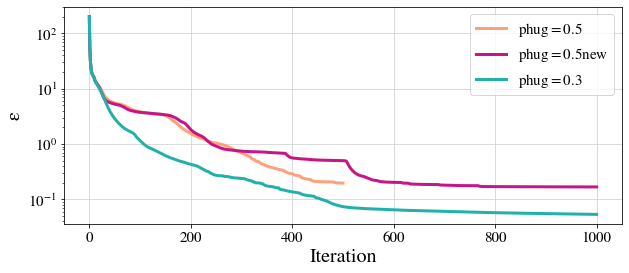

In [82]:
rc('font',**{'family':'STIXGeneral'})
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(B10N5k_HAN.εs, label='phug'+ r'$\mathregular{=0.5}$', color='lightsalmon', lw=3)
ax.plot(B10N5k_HAN_05.εs, label='phug'+ r'$\mathregular{=0.5}$' + 'new', color='mediumvioletred', lw=3)
ax.plot(B10N5k_HAN_03.εs, label='phug' + r'$\mathregular{=0.3}$', color='lightseagreen', lw=3)
ax.set_xlabel("Iteration", fontsize=20)
ax.set_ylabel(r"$\mathregular{\epsilon}$", fontsize=20)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)
ax.set_yscale('log')
ax.grid(True, color='lightgray')
plt.show()